In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy

In [3]:
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams['font.size'] = 14
plt.rcParams['figure.dpi'] = 300

## 1. The Data

In [4]:
data = pd.read_excel('./data.xlsx')
data = data.drop(columns=['S/N'])
data.head()

,cDen,Pot,Sn %,pH,C2H4,CO,H2,EtoH,FORM
0,150,3.5,100,14.05,0,23,12,0,61
1,150,3.3,80,14.05,0,23,7,0,66
2,150,3.2,50,14.05,0,34,5,3,52
3,150,3.1,10,14.05,1,42,5,2,42
4,150,3.0,5,14.05,4,48,5,10,19


In [5]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cDen,35.0,269.171429,119.205824,141.00,150.00,250.00,350.00,450.00
Pot,35.0,3.860000,0.500118,2.80,3.55,4.00,4.15,4.70
Sn %,35.0,35.428571,38.820314,0.00,3.00,10.00,80.00,100.00
pH,35.0,12.844000,2.447214,8.02,14.05,14.05,14.05,14.05
C2H4,35.0,7.971429,10.348304,0.00,0.00,4.00,9.50,37.00
CO,35.0,21.942857,12.311981,5.00,12.50,19.00,27.50,50.00
H2,35.0,13.742857,9.344211,5.00,7.00,10.00,15.50,37.00
EtoH,35.0,10.600000,13.211403,0.00,0.00,6.00,14.00,48.00
FORM,35.0,35.371429,21.706716,7.00,14.00,38.00,54.00,70.00


In [6]:
features_col = list(data.columns[:4])
target_col = list(data.columns[4:])
print('Features: ', features_col)
print('Target: ', target_col)

Features:  ['cDen', 'Pot', 'Sn %', 'pH']
Target:  ['C2H4', 'CO', 'H2', 'EtoH', 'FORM']


In [7]:
# normalize the data in target columns by 100
data[target_col] = data[target_col] / 100
data.head(2)

,cDen,Pot,Sn %,pH,C2H4,CO,H2,EtoH,FORM
0,150,3.5,100,14.05,0.0,0.23,0.12,0.0,0.61
1,150,3.3,80,14.05,0.0,0.23,0.07,0.0,0.66


In [8]:
data[features_col[2]] = data[features_col[2]] / 100
data.head(2)

,cDen,Pot,Sn %,pH,C2H4,CO,H2,EtoH,FORM
0,150,3.5,1.0,14.05,0.0,0.23,0.12,0.0,0.61
1,150,3.3,0.8,14.05,0.0,0.23,0.07,0.0,0.66


In [9]:
def cu_fraction(Sn):
    '''Calculates the fraction of Cu in the catalyst
    params:
        Sn: float, the percentage of Sn in the catalyst
    returns:
        Cu: float, the percentage of Cu in the catalyst
    '''
    if Sn <= 1:
        Cu = 1 - Sn
    else:
        raise ValueError('Sn percent must be less than or equal to 1')
    return Cu

def get_weight(Sn):
    '''Calculates the weight of the catalyst
    params:
        Sn: float, the percentage of Sn in the catalyst
    returns:
        weight: float, the weight of the catalyst
    '''
    # create the structure
    if Sn <= 1:
        weight = (1 - Sn)*63.546 + (Sn)*118.71
    else:
        raise ValueError('Sn percent must be less than or equal to 1')
    return weight

In [10]:
data['weight'] = data['Sn %'].apply(get_weight)
data['Cu %'] = 1 - data['Sn %']
data.head(5)

,cDen,Pot,Sn %,pH,C2H4,CO,H2,EtoH,FORM,weight,Cu %
0,150,3.5,1.00,14.05,0.00,0.23,0.12,0.00,0.61,118.7100,0.00
1,150,3.3,0.80,14.05,0.00,0.23,0.07,0.00,0.66,107.6772,0.20
2,150,3.2,0.50,14.05,0.00,0.34,0.05,0.03,0.52,91.1280,0.50
3,150,3.1,0.10,14.05,0.01,0.42,0.05,0.02,0.42,69.0624,0.90
4,150,3.0,0.05,14.05,0.04,0.48,0.05,0.10,0.19,66.3042,0.95


In [11]:
features_col += ['weight', 'Cu %']

In [12]:
# reassign the features and target columns
data = data[features_col + target_col]
data.head(2)

,cDen,Pot,Sn %,pH,weight,Cu %,C2H4,CO,H2,EtoH,FORM
0,150,3.5,1.0,14.05,118.7100,0.0,0.0,0.23,0.12,0.0,0.61
1,150,3.3,0.8,14.05,107.6772,0.2,0.0,0.23,0.07,0.0,0.66


In [13]:
normalize_features = False

if normalize_features:
    data[features_col] = data[features_col] / data[features_col].max()
data.head(2)

,cDen,Pot,Sn %,pH,weight,Cu %,C2H4,CO,H2,EtoH,FORM
0,150,3.5,1.0,14.05,118.7100,0.0,0.0,0.23,0.12,0.0,0.61
1,150,3.3,0.8,14.05,107.6772,0.2,0.0,0.23,0.07,0.0,0.66


## 2. Analyze Data

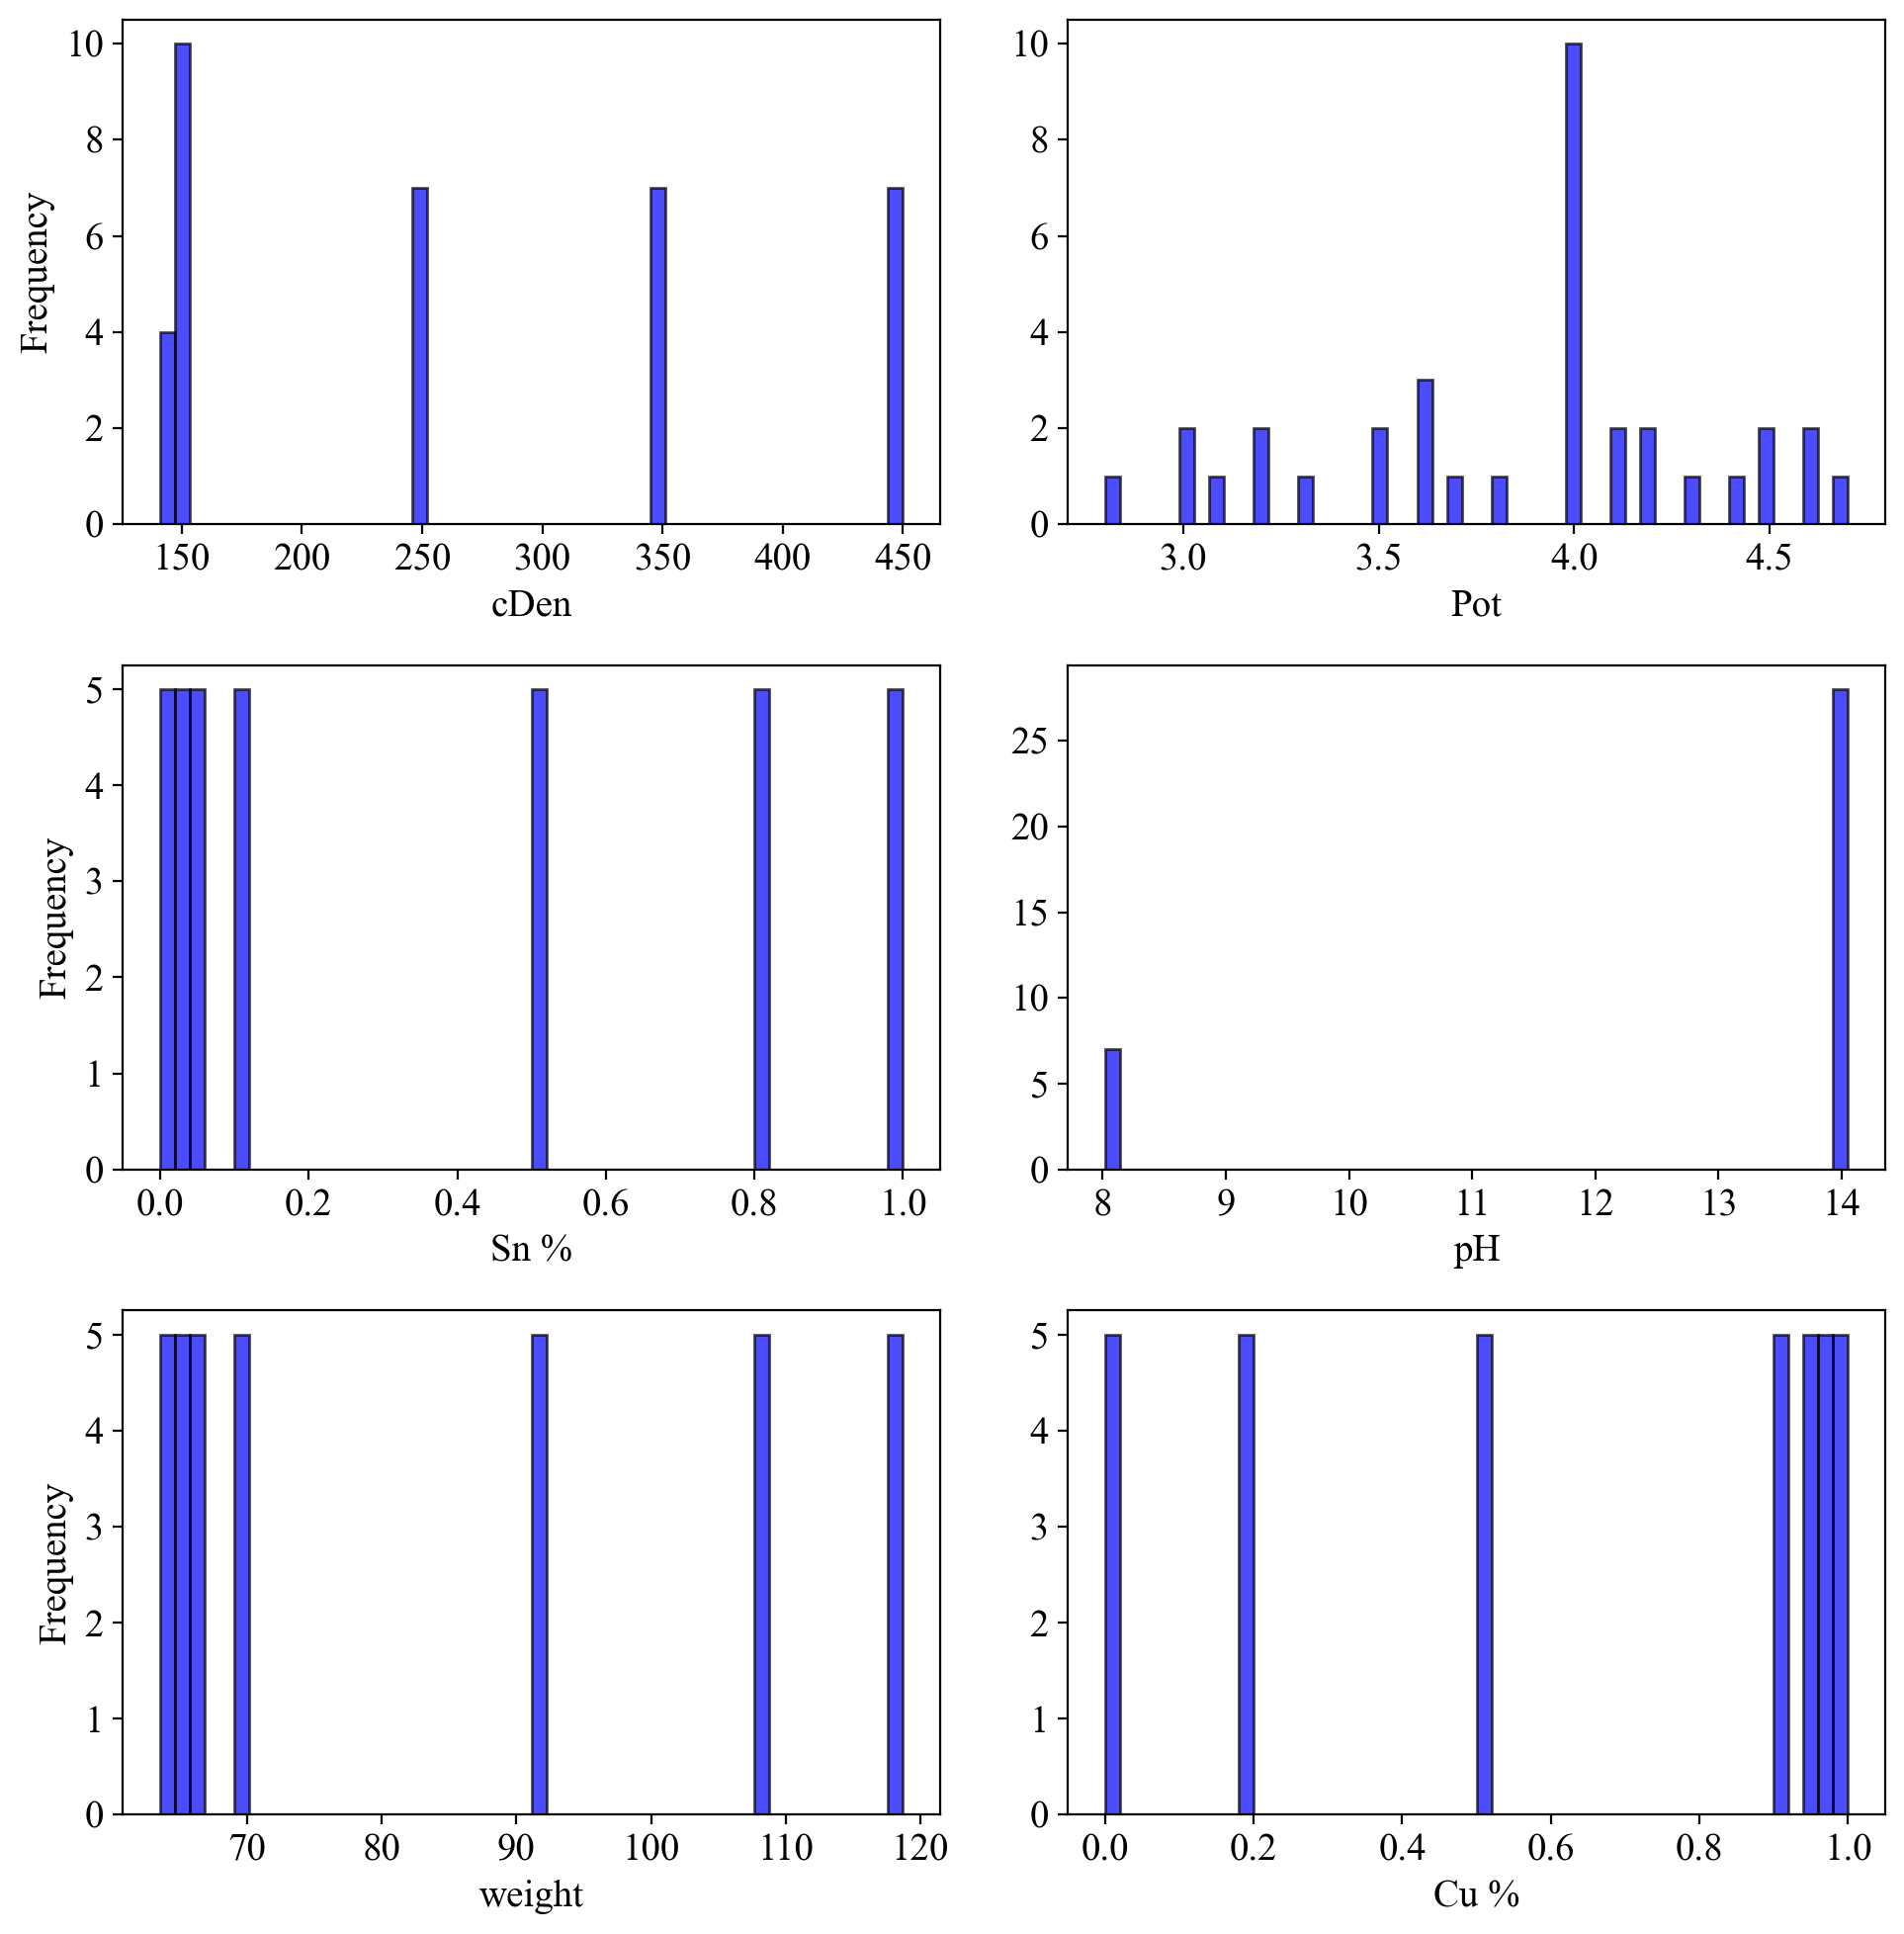

In [14]:
# show histogram for all features with subplots
plt.figure(figsize=(10, 10), dpi=200)
for i, feature in enumerate(features_col):
    plt.subplot(3, 2, i+1)
    k = plt.hist(data[feature], bins=50, alpha=0.7, color='blue', edgecolor='black')
    plt.xlabel(feature)
    
    if i%2 == 0:
        plt.ylabel('Frequency')
plt.tight_layout()

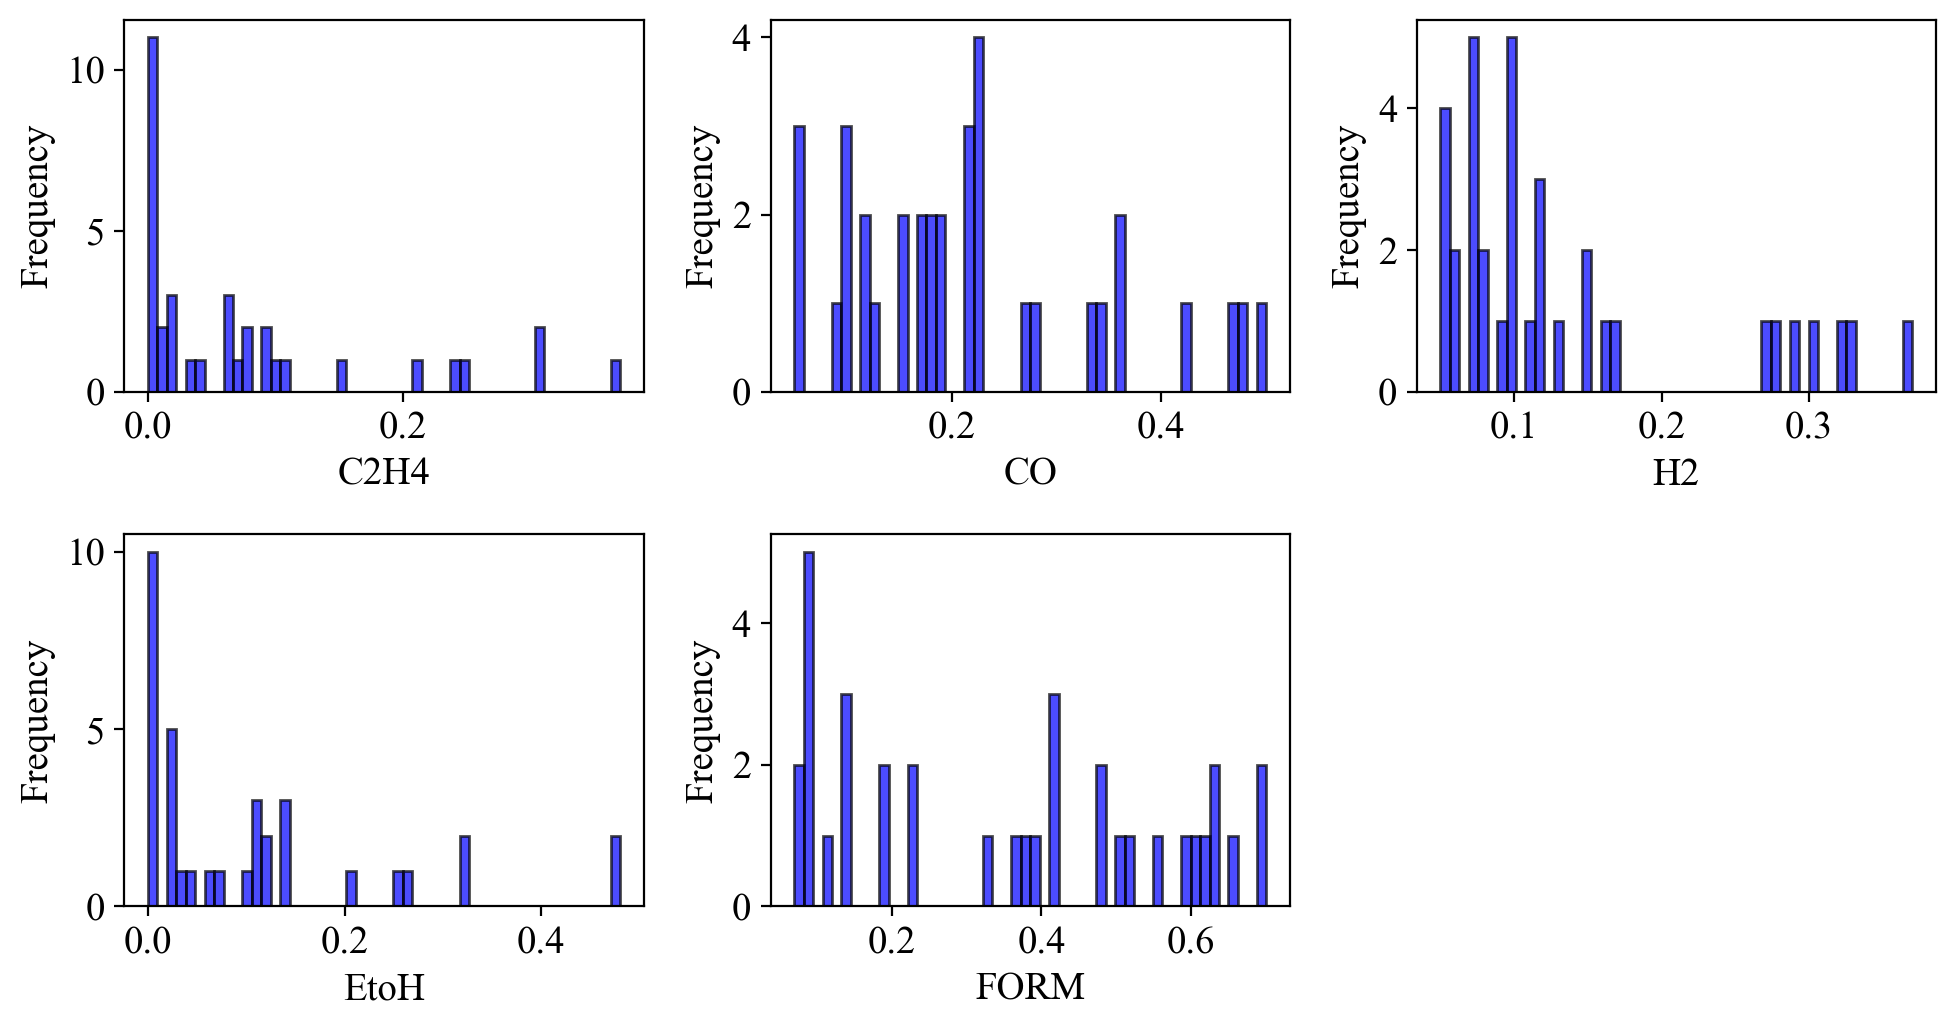

In [15]:
# show histogram for all features with subplots
plt.figure(figsize=(10, 10), dpi=200)
for i, feature in enumerate(target_col):
    plt.subplot(4, 3, i+1)
    k = plt.hist(data[feature], bins=50, alpha=0.7, color='blue', edgecolor='black')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.tight_layout()

In [16]:
correlation = data.corr(method='pearson')

In [17]:
def plot_heat_map(
                    data: pd.DataFrame = None, mask: bool = False, compute_corr: bool = True,
                    fig_size = (10, 5), save_fig: bool = False, name: str = 'general'
                    ):
    ''' Plot the heatmap of the correlation matrix of the data  '''
        
    fig, ax = plt.subplots(1, figsize=fig_size, facecolor='white')

    # Create the heatmap for the original data
    if compute_corr:
        corr = data.corr(method='pearson')
    else:
        corr = data
    if mask is False:
        sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.2f', linewidths=.5, ax=ax, cbar=False)
    else: # mask the diagonal
        mask = np.triu(np.ones_like(corr, dtype=bool))
        sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.2f', linewidths=.5, ax=ax, cbar=False, mask=mask)
        
    # Show the plot
    plt.show()
    if save_fig:
        fig.savefig(f'./reports/heatmap_{name}.png', dpi=200)

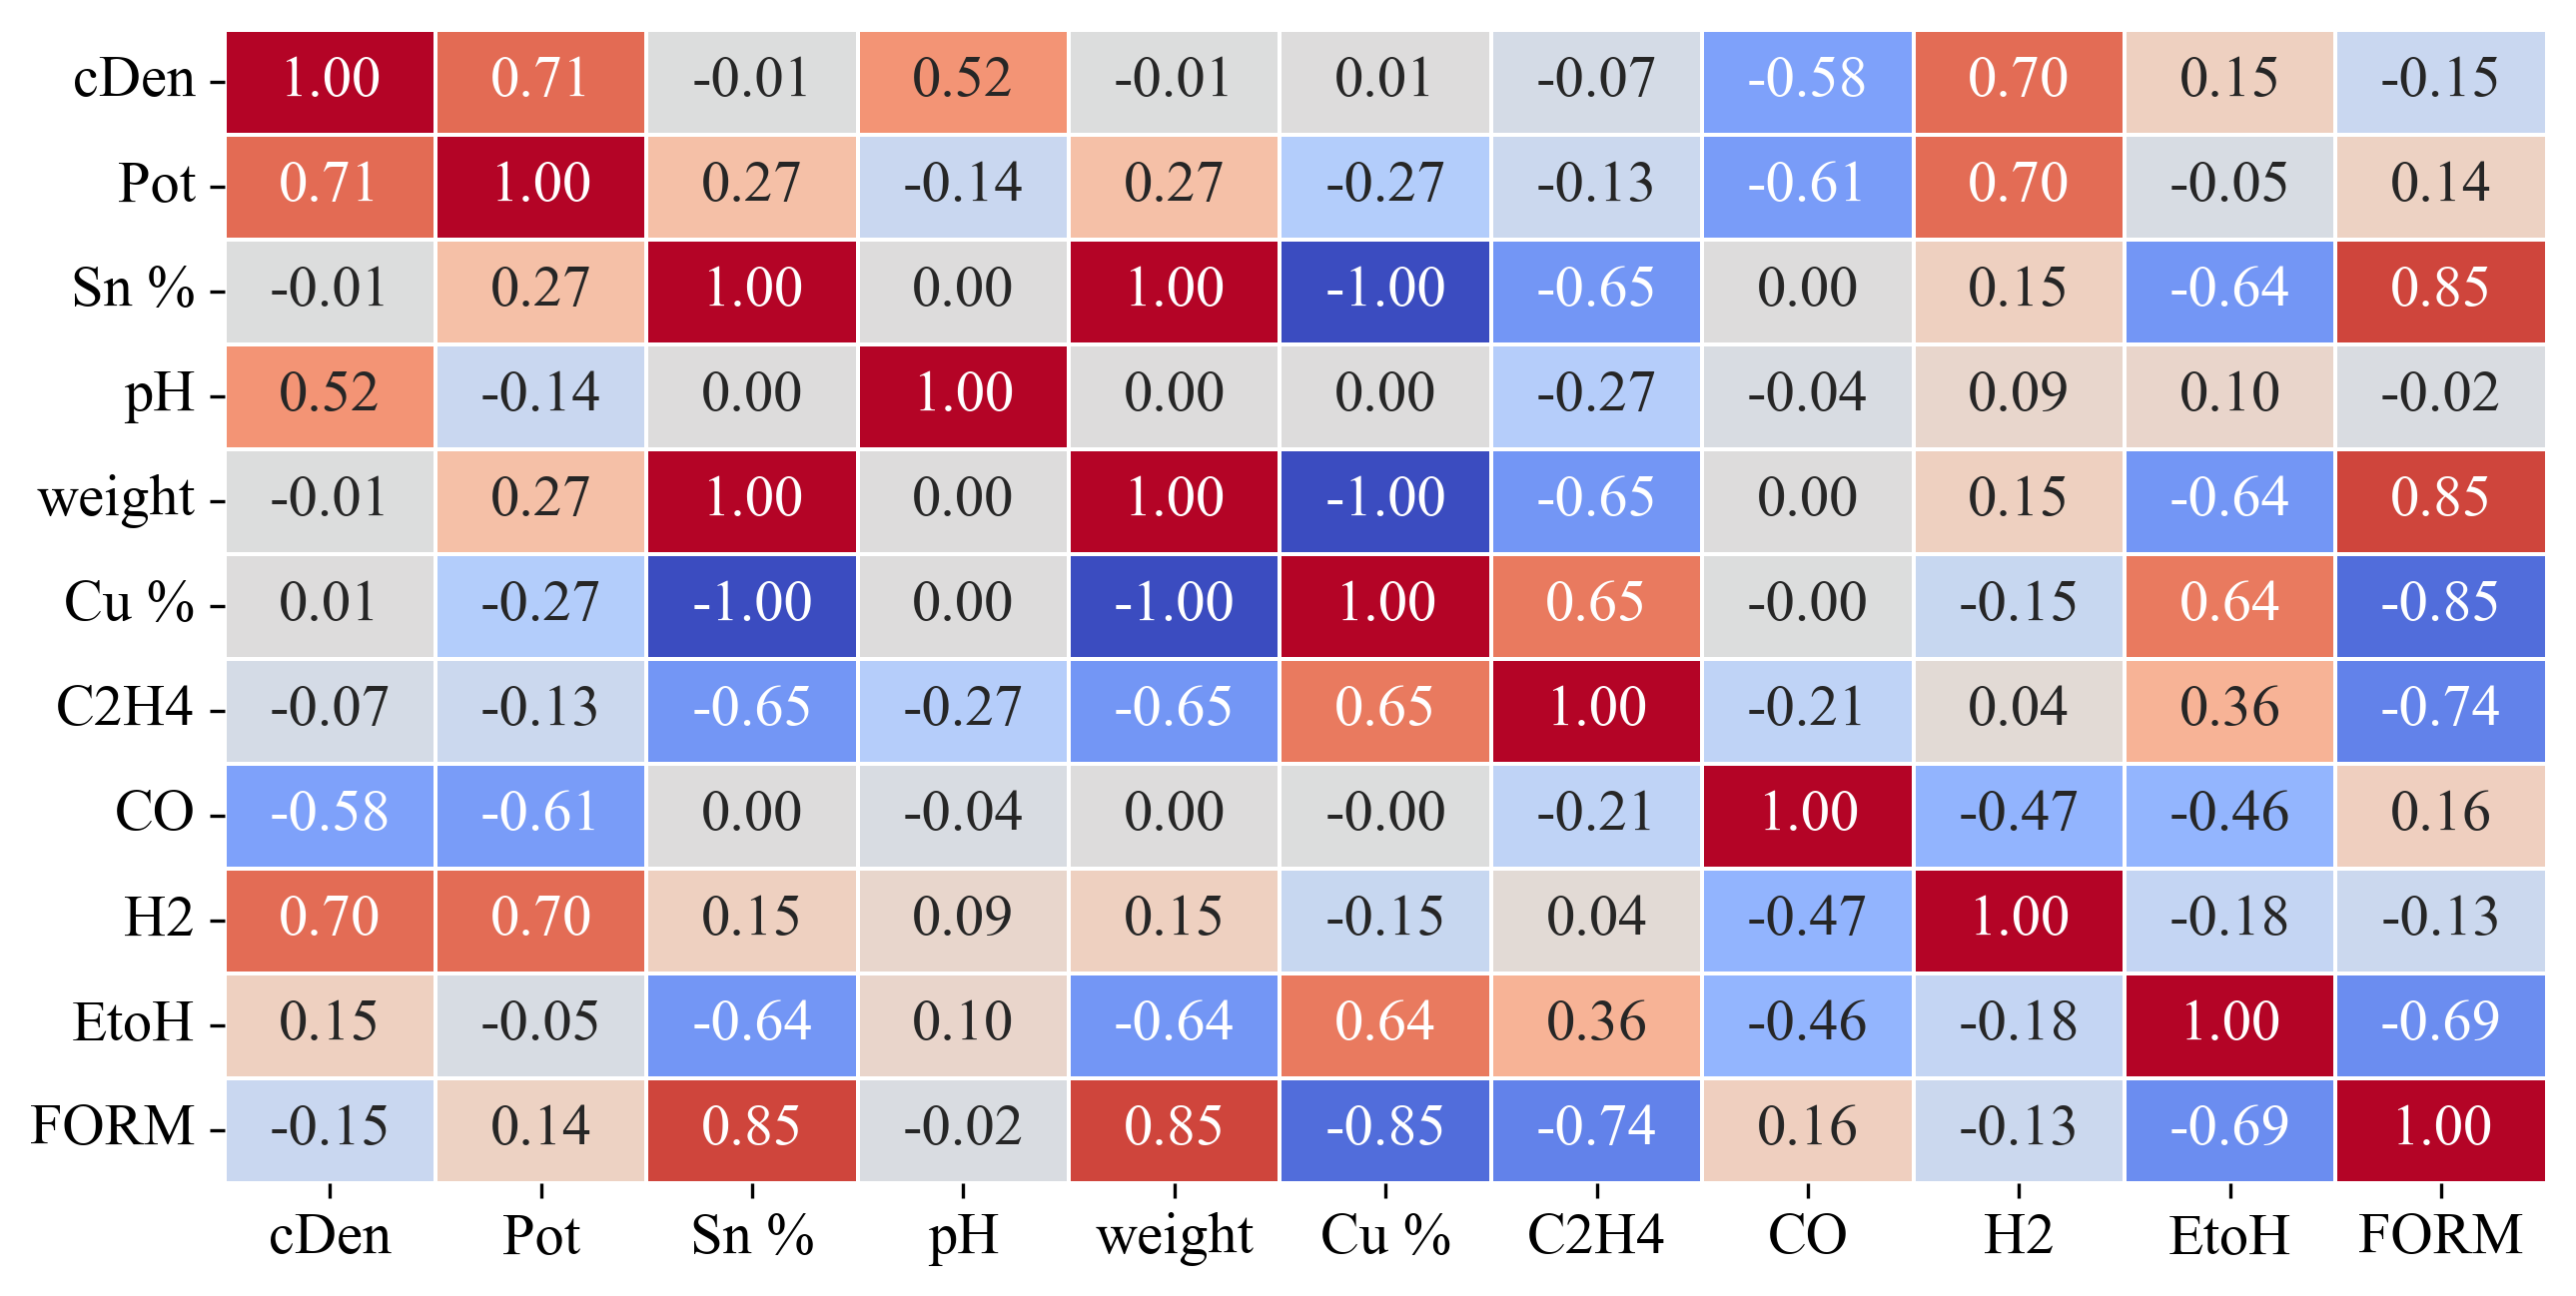

In [18]:
plot_heat_map(data = correlation, compute_corr = False, fig_size = (10, 5), mask=False, save_fig=False, name='general_no_mask')

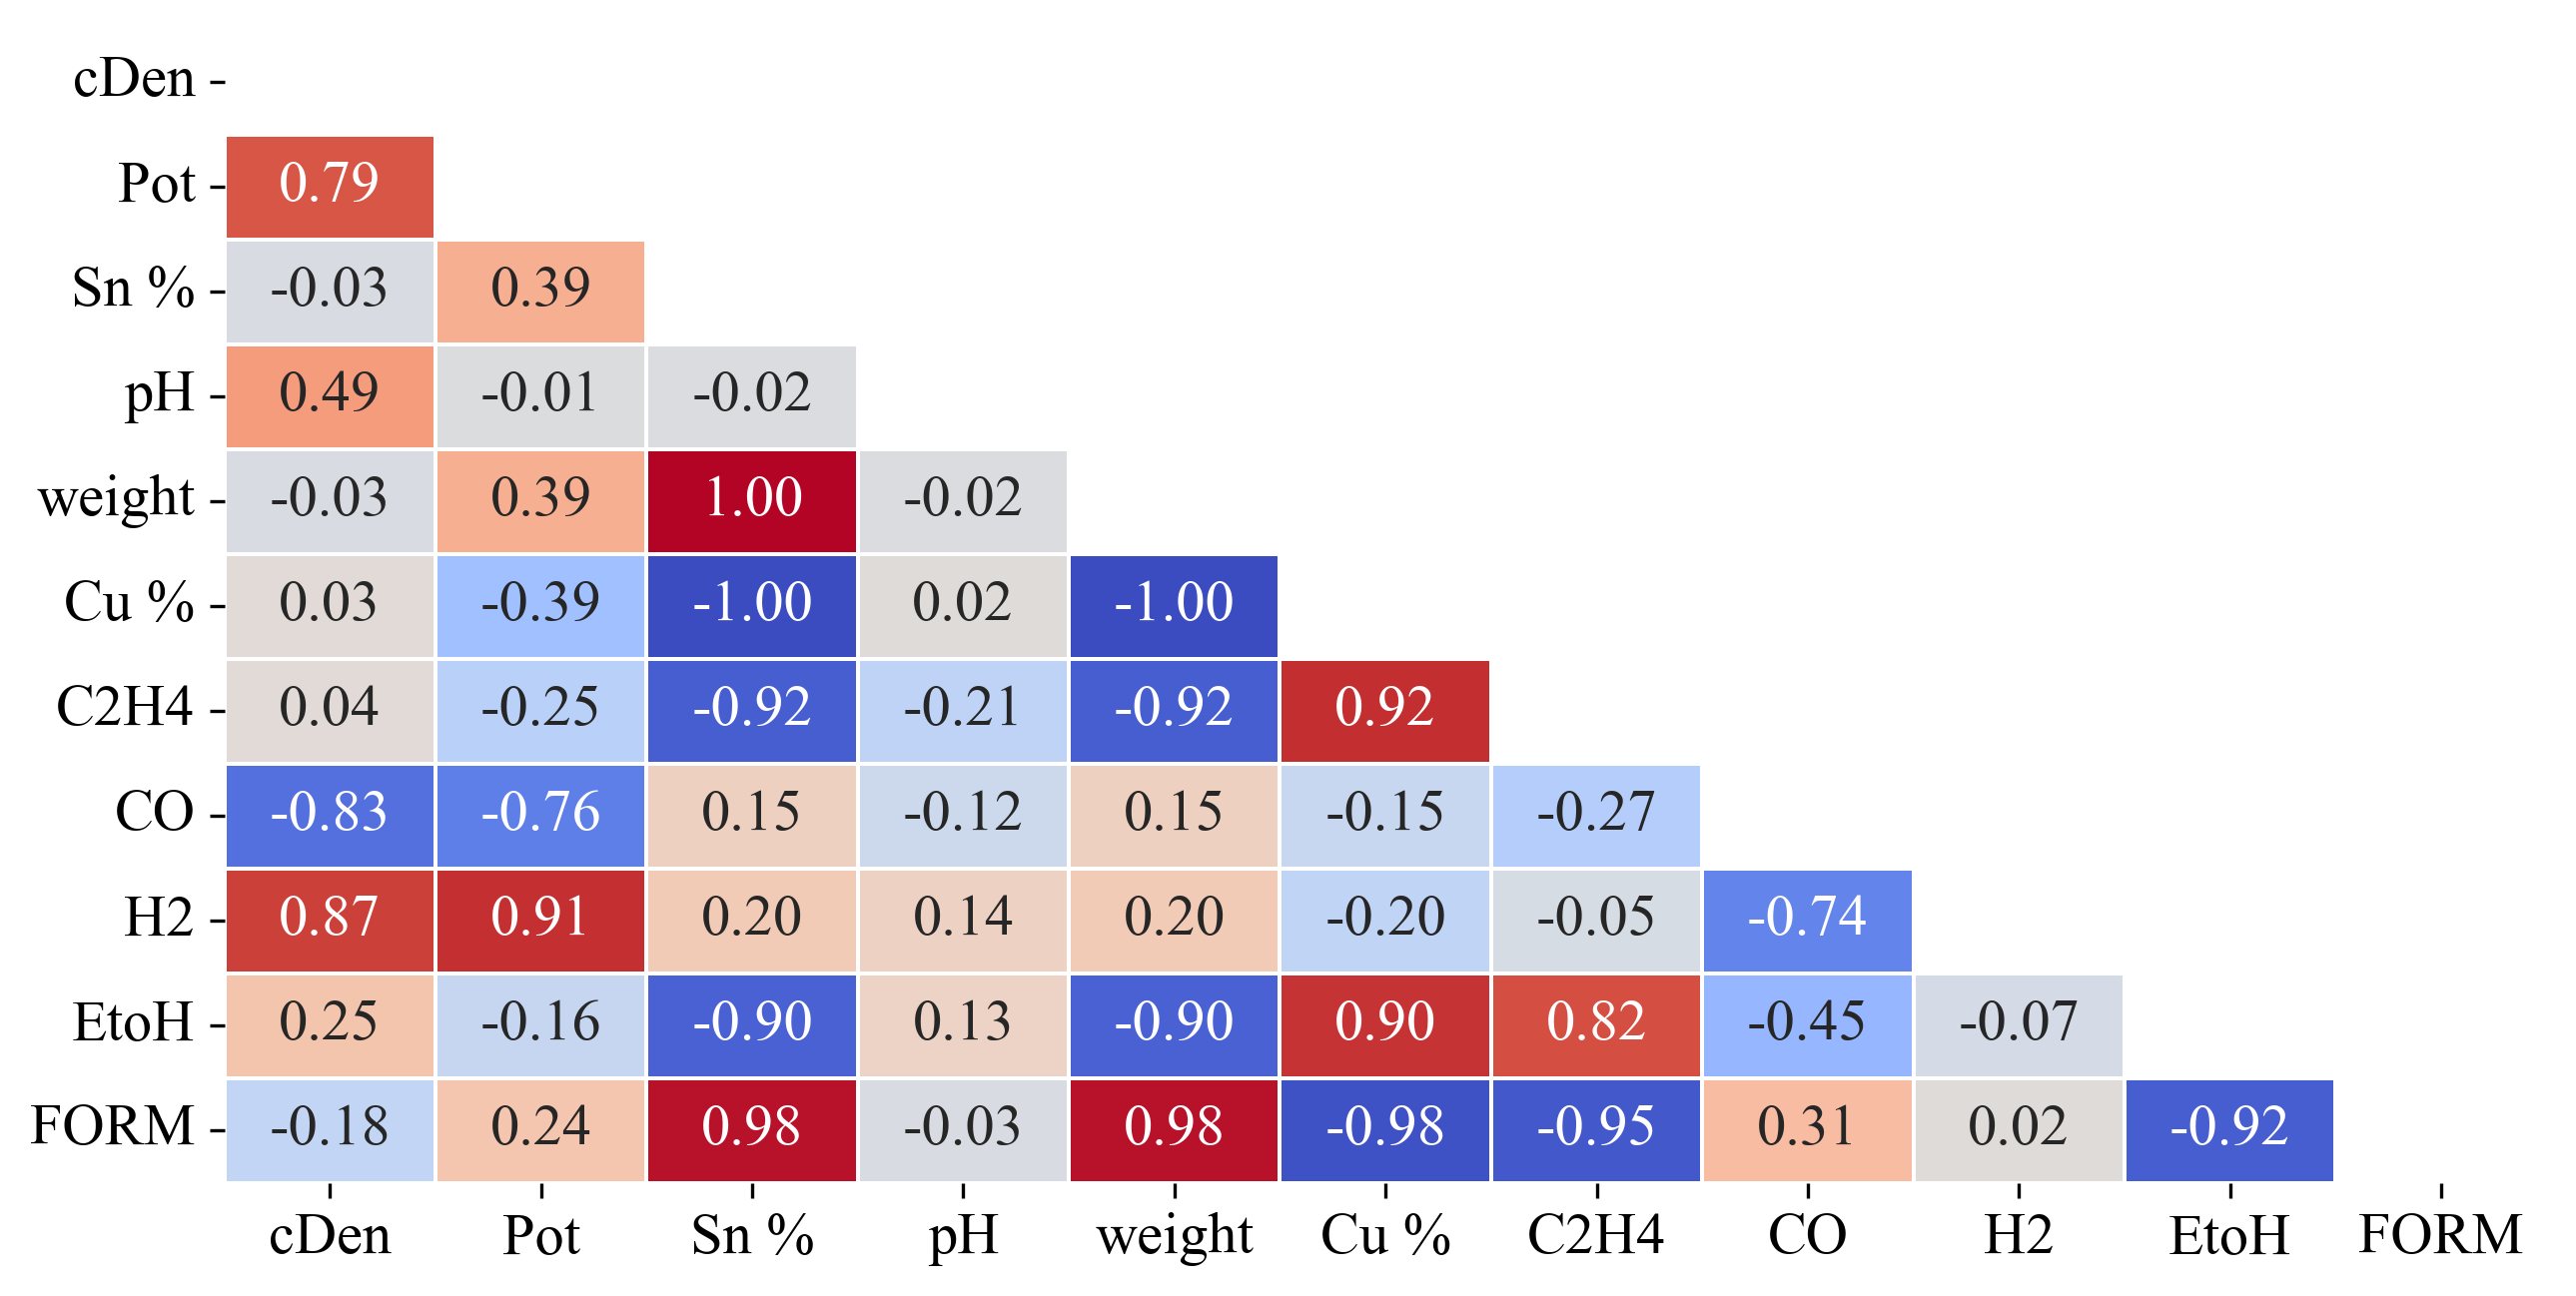

In [19]:
plot_heat_map(data = correlation, compute_corr = True, fig_size = (10, 5), mask=True, save_fig=False, name='general_mask')

In [20]:
ethane = {
        r'$\rm cDen$': -0.07, r'$\rm Pot$': -0.13, r'$\rm Sn \ \%$': -0.65, 
        r'$\rm pH$': -0.27, r'$\rm Cu \ \%$': 0.65, r'$\rm weight$': -0.65}
co = {
        r'$\rm cDen$': -0.58, r'$\rm Pot$': -0.61, r'$\rm Sn \ \%$': 0.00, 
        r'$\rm pH$': -0.04, r'$\rm Cu \ \%$': -0.00, r'$\rm weight$': 0.00
        }
hydrogen = {
        r'$\rm cDen$': 0.70, r'$\rm Pot$': 0.70, r'$\rm Sn \ \%$': 0.15, 
        r'$\rm pH$': 0.09, r'$\rm Cu \ \%$': -0.15, r'$\rm weight$': 0.15
        }
ethOH = {
    r'$\rm cDen$': 0.15, r'$\rm Pot$': -0.05, r'$\rm Sn \ \%$': -0.64, 
    r'$\rm pH$': 0.10, r'$\rm Cu \ \%$': 0.64, r'$\rm weight$': -0.64
    }
form = {
    r'$\rm cDen$': -0.15, r'$\rm Pot$': 0.14, r'$\rm Sn \ \%$': 0.85, 
    r'$\rm pH$': -0.02, r'$\rm Cu \ \%$': -0.85, r'$\rm weight$': 0.85
    }

heat = pd.DataFrame([ethane, co, hydrogen, ethOH, form])
heat.index = [r'$\rm C_2H_4$', r'$\rm CO$', r'$\rm H_2$', r'$\rm C_2H_5OH$', r'$\rm HCOOH$']
heat


,$\rm cDen$,$\rm Pot$,$\rm Sn \ \%$,$\rm pH$,$\rm Cu \ \%$,$\rm weight$
$\rm C_2H_4$,-0.07,-0.13,-0.65,-0.27,0.65,-0.65
$\rm CO$,-0.58,-0.61,0.00,-0.04,-0.00,0.00
$\rm H_2$,0.70,0.70,0.15,0.09,-0.15,0.15
$\rm C_2H_5OH$,0.15,-0.05,-0.64,0.10,0.64,-0.64
$\rm HCOOH$,-0.15,0.14,0.85,-0.02,-0.85,0.85


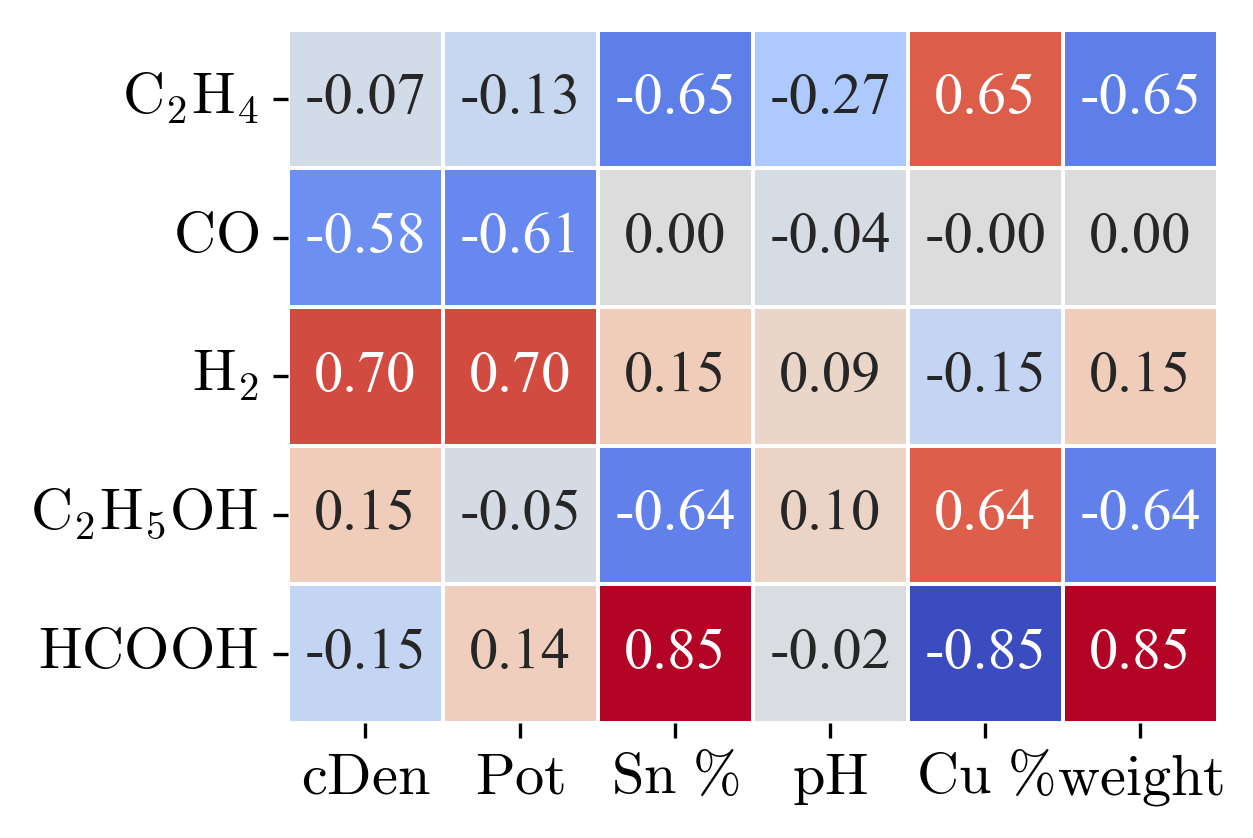

In [21]:
plot_heat_map(data = heat, fig_size = (4, 3), mask=False, compute_corr=False, save_fig=False)

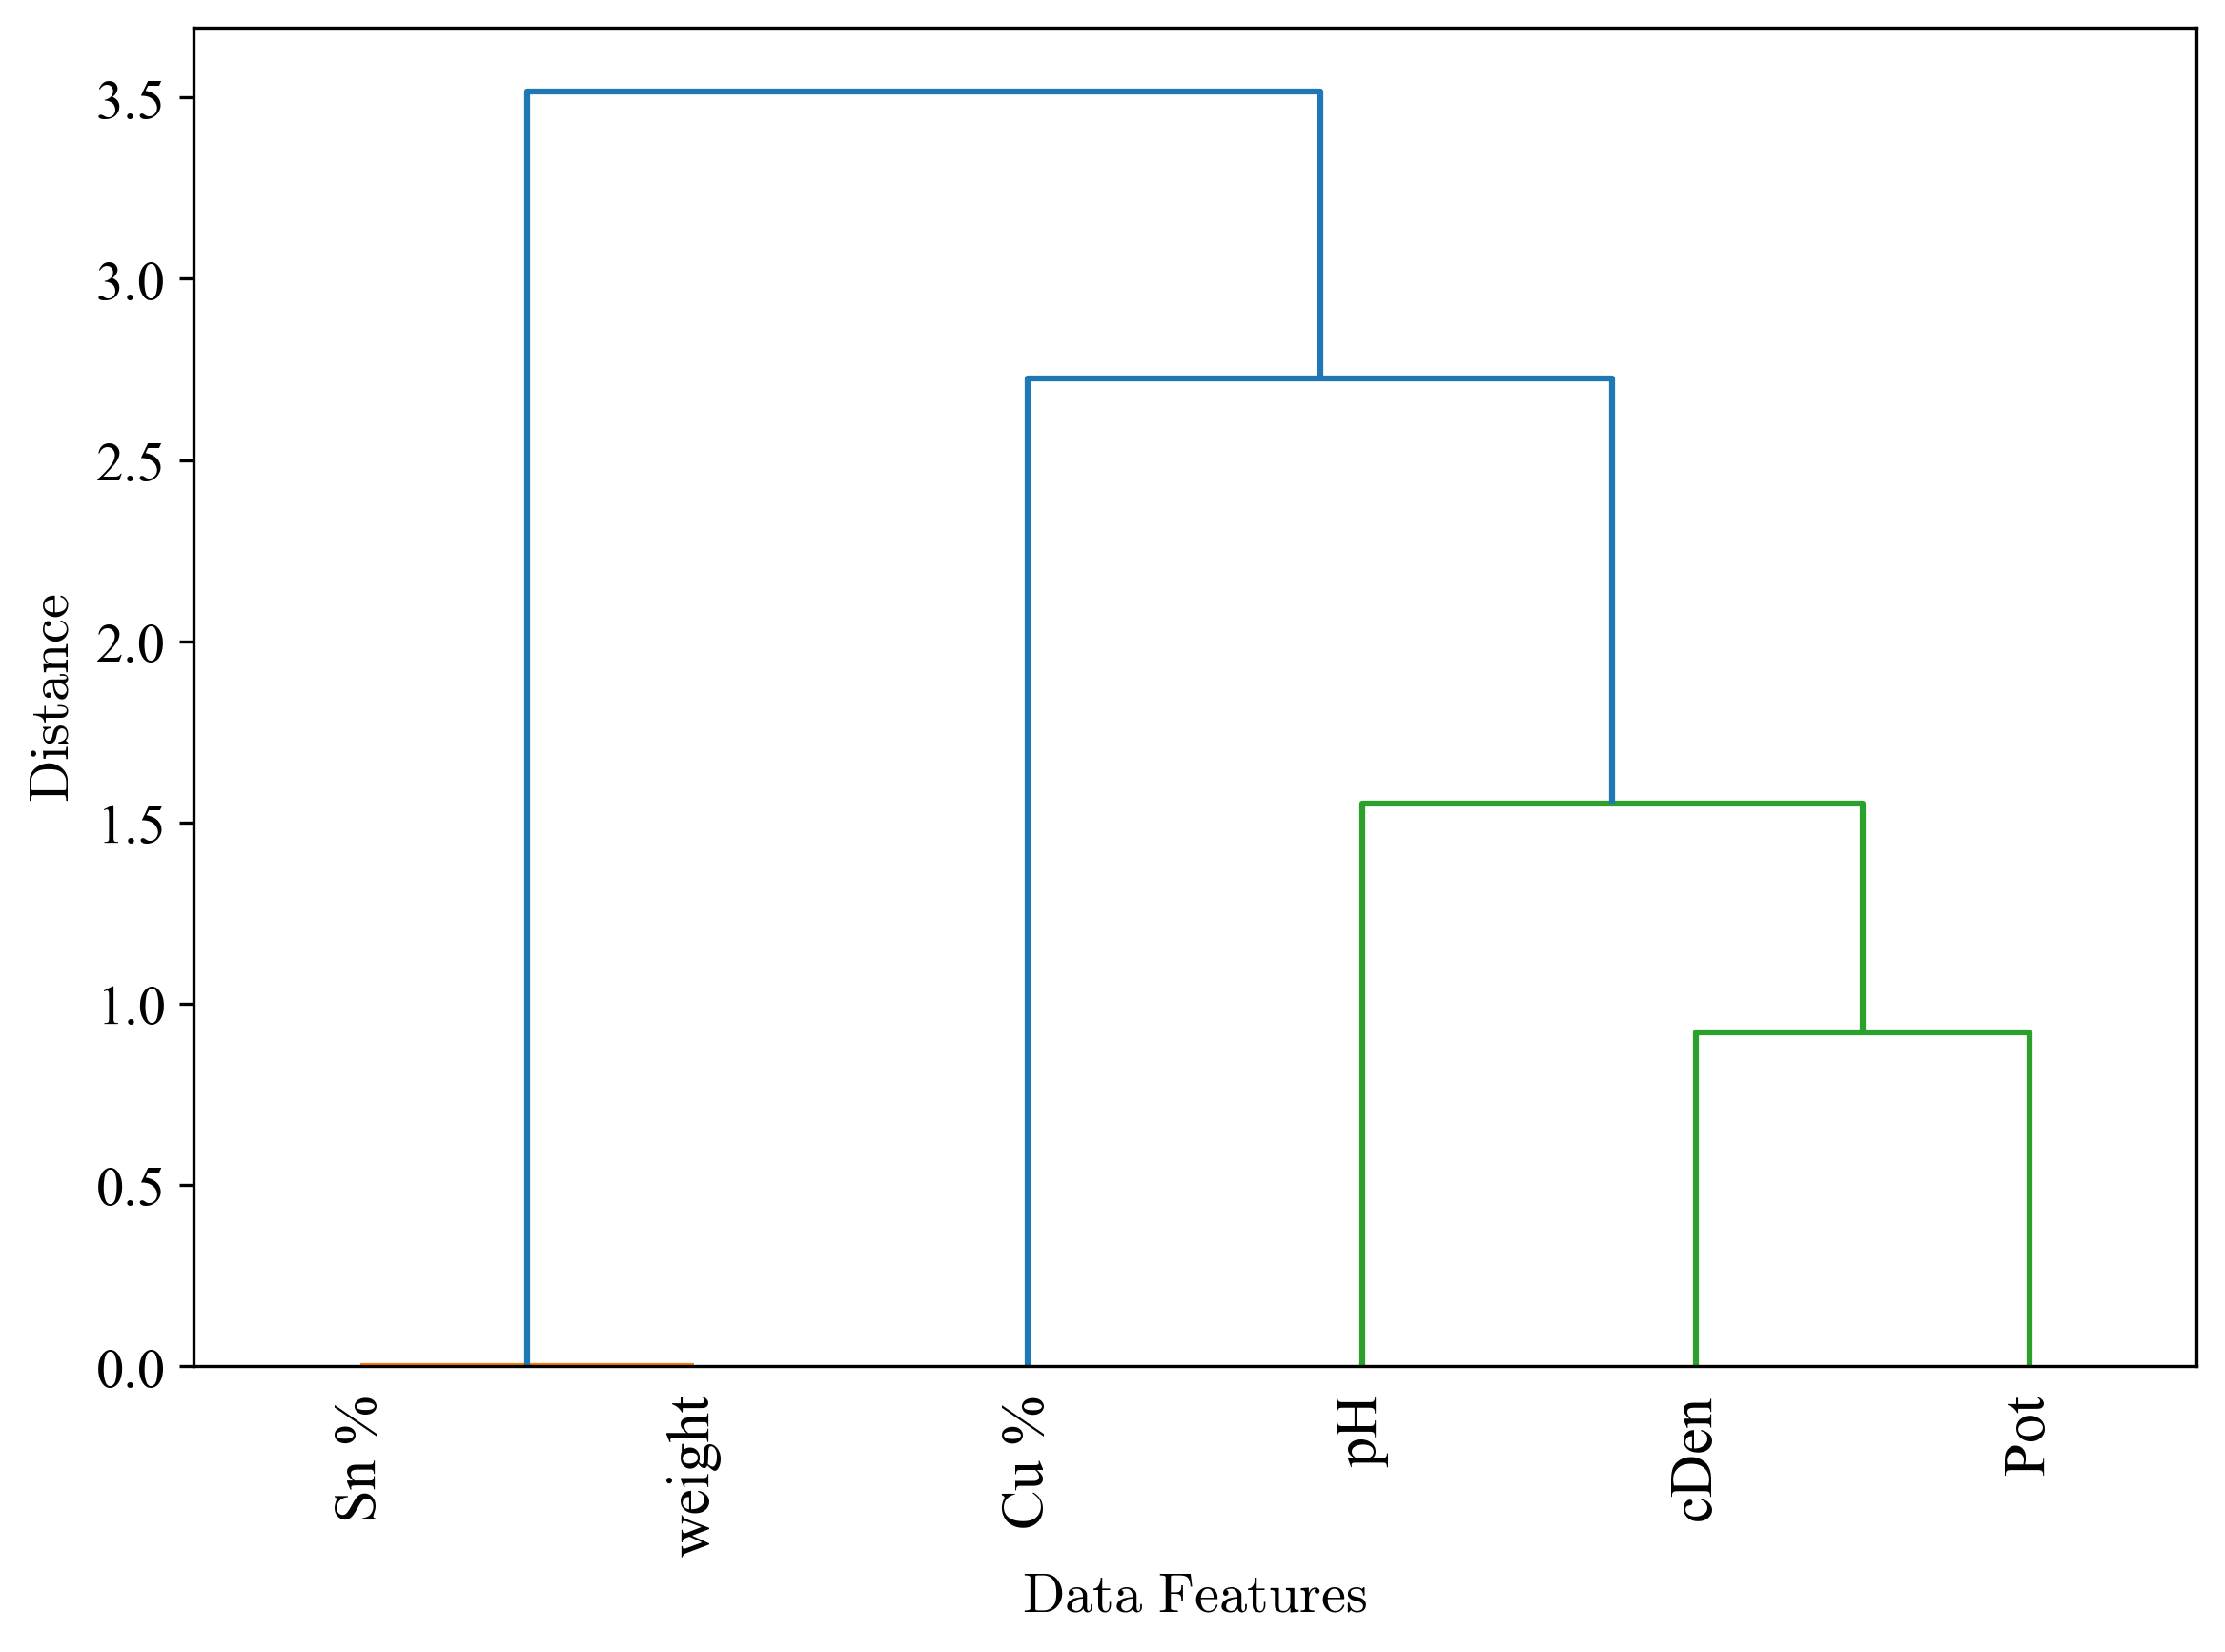

In [22]:
# 
feature_correlation = data[features_col].corr(method='pearson')
# Perform hierarchical clustering
linkage_matrix = hierarchy.linkage(feature_correlation, method='ward')
# Display hierarchical clustering with feature names
fig = plt.figure(figsize=(8, 6))
dendrogram = hierarchy.dendrogram(linkage_matrix, labels=features_col, orientation='top', leaf_font_size=15)

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=90)
plt.xlabel(r"$\rm Data \ Features$")
plt.ylabel(r"$\rm Distance$")
plt.tight_layout()
plt.show()